In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import (
    train_test_split,
    RepeatedStratifiedKFold,
    GridSearchCV,
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scikitplot.metrics import plot_roc, plot_precision_recall

In [2]:
df_orig = pd.read_csv('dataset/preprocessed_dataset.csv')
df_orig = df_orig.drop(['intensity', 'sc_min', 'stft_min'], axis=1)
df_orig.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,sex,length_ms,frame_count,zero_crossings_sum,mfcc_mean,...,sc_max,sc_kur,sc_skew,stft_mean,stft_std,stft_kur,mean,std,kur,skew
0,1,3,0,0,1,0,3737,179379.0,1.121235,-1.057124,...,13541.959028,0.674807,-0.276204,-0.734044,0.175085,-1.215025,3.844916e-07,0.014482,9.406061,0.706488
1,1,0,0,0,0,0,3904,187387.0,0.278471,-0.164264,...,12000.290443,0.264372,-0.365037,-0.706940,0.883757,-1.384174,-7.149491e-08,0.020417,19.564187,0.748262
2,0,4,1,0,1,0,4671,224224.0,1.592681,-0.395188,...,12007.751173,0.665423,0.250018,-1.163996,0.879099,-1.242947,2.429985e-06,0.024317,4.881241,0.771346
3,1,7,0,1,0,0,3637,174575.0,-0.346031,-1.633922,...,12048.223893,0.297811,-0.707183,-0.830636,1.227493,-1.445318,2.373929e-07,0.003561,13.040259,-0.072032
4,0,4,1,0,1,0,4404,211411.0,0.614322,-0.590964,...,12025.582707,0.628032,0.418192,-0.725278,0.811169,-1.366742,8.454691e-07,0.027522,7.485109,1.018009


In [3]:
emotion_dict = {0: 'angry', 1: 'calm', 2: 'disgust', 3: 'fearful', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprised'}
df_orig['emotion'] = df_orig['emotion'].map(emotion_dict)

one_hot = pd.get_dummies(df_orig['emotion'])
df_orig = df_orig.join(one_hot)
df_orig = df_orig.drop(['emotion'], axis=1)
df_orig.columns

Index(['vocal_channel', 'emotional_intensity', 'statement', 'repetition',
       'sex', 'length_ms', 'frame_count', 'zero_crossings_sum', 'mfcc_mean',
       'mfcc_std', 'mfcc_max', 'sc_mean', 'sc_std', 'sc_max', 'sc_kur',
       'sc_skew', 'stft_mean', 'stft_std', 'stft_kur', 'mean', 'std', 'kur',
       'skew', 'angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral',
       'sad', 'surprised'],
      dtype='object')

In [4]:
df = df_orig.drop(['vocal_channel'], axis=1)
target = df_orig['vocal_channel']

X = df.values
y = target.values

# Partitioning

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, stratify=y_train, random_state=0
) # 0.25 x 0.8 = 0.2

In [6]:
print(np.unique(y, return_counts=True)[1] / len(y))
print(np.unique(y_train, return_counts=True)[1] / len(y_train))
print(np.unique(y_val, return_counts=True)[1] / len(y_val))
print(np.unique(y_test, return_counts=True)[1] / len(y_test))

[0.40933499 0.59066501]
[0.40909091 0.59090909]
[0.40909091 0.59090909]
[0.41030928 0.58969072]


In [7]:
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(1452, 30) (484, 30) (485, 30) (1452,) (484,) (485,)


# Decision tree

In [8]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

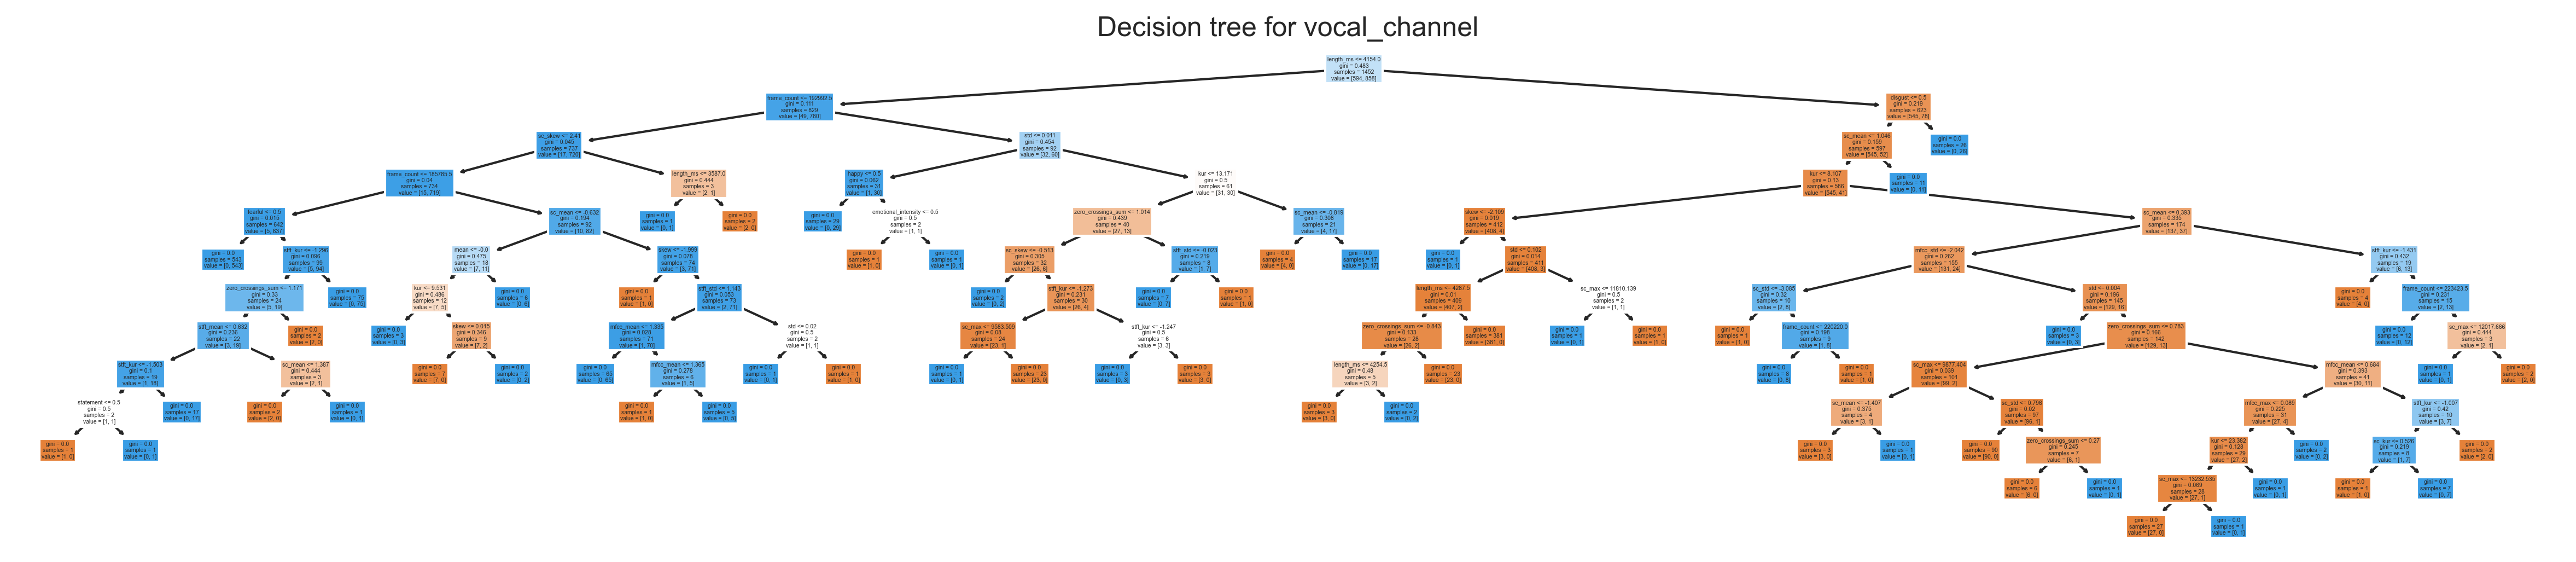

In [9]:
plt.figure(figsize=(20, 4), dpi=300)
plot_tree(clf, feature_names=df.columns, filled=True)
plt.title('Decision tree for vocal_channel')
plt.show()

In [10]:
y_test_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_test_pred))
print(f1_score(y_test, y_test_pred, average='macro'))

0.931958762886598
0.9297499440369751


In [11]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       199
           1       0.94      0.94      0.94       286

    accuracy                           0.93       485
   macro avg       0.93      0.93      0.93       485
weighted avg       0.93      0.93      0.93       485



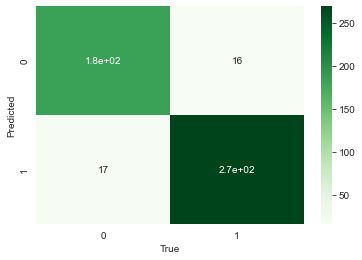

In [12]:
cf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

In [13]:
y_test_pred_proba = clf.predict_proba(X_test)

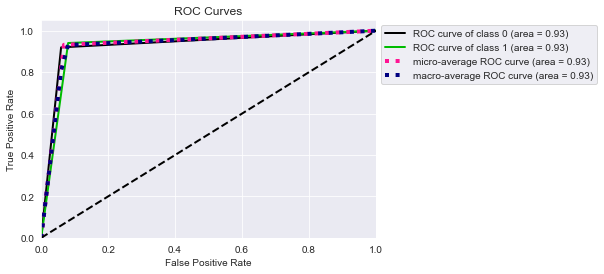

0.9300787152545945


In [14]:
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

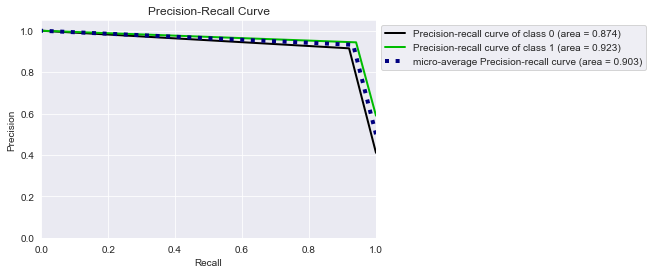

In [15]:
plot_precision_recall(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

## Grid search

In [16]:
param_grid = {
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 3, 5, 10],
    'max_depth': [2, 4, 6, 8, 10, 16, None],
    'criterion': ['gini', 'entropy', 'log_loss']
}

grid = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0),
    n_jobs=-1,
    refit=True,
)

In [17]:
grid.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=0),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4, 6, 8, 10, 16, None],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'min_samples_split': [2, 3, 5, 10]})

In [18]:
clf = grid.best_estimator_

In [19]:
criterion = grid.best_params_['criterion']
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']
min_samples_split = grid.best_params_['min_samples_split']
print(grid.best_params_, grid.best_score_)

{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 10} 0.9309911126910773


In [20]:
clf.score(X_test, y_test)

0.9278350515463918

## Post-pruning: Minimal Cost-Complexity Pruning

In [21]:
# return the effective alphas and the corresponding total leaf impurities at each step of the pruning process
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

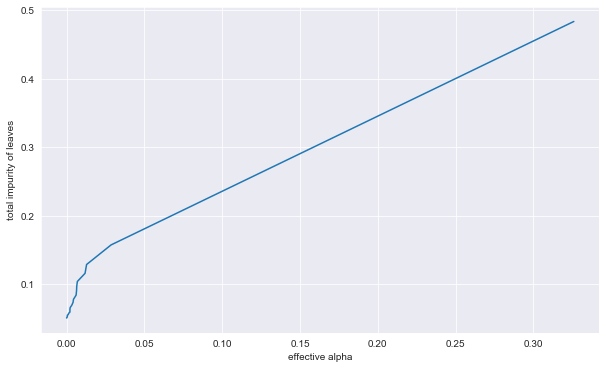

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities)
plt.xlabel('effective alpha')
plt.ylabel('total impurity of leaves')
plt.show()

In [23]:
clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                                 min_samples_split=min_samples_split, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

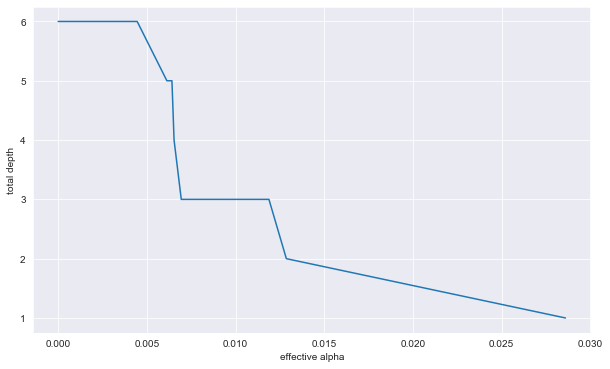

In [24]:
tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel('effective alpha')
plt.ylabel('total depth')
plt.show()

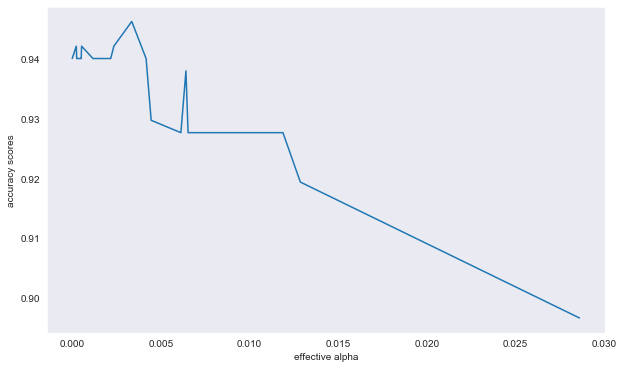

In [25]:
acc_scores = [accuracy_score(y_val, clf.predict(X_val)) for clf in clfs]

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel('effective alpha')
plt.ylabel('accuracy scores')
plt.show()

In [26]:
index = np.argmax(acc_scores)
alpha = ccp_alphas[index]
print(f'score: {acc_scores[index]}, alpha: {alpha}')

score: 0.9462809917355371, alpha: 0.0033582579037124503


In [27]:
clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                             min_samples_split=min_samples_split, ccp_alpha=alpha)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0033582579037124503, max_depth=6,
                       min_samples_leaf=5, min_samples_split=10)

In [28]:
clf.score(X_test, y_test)

0.9484536082474226

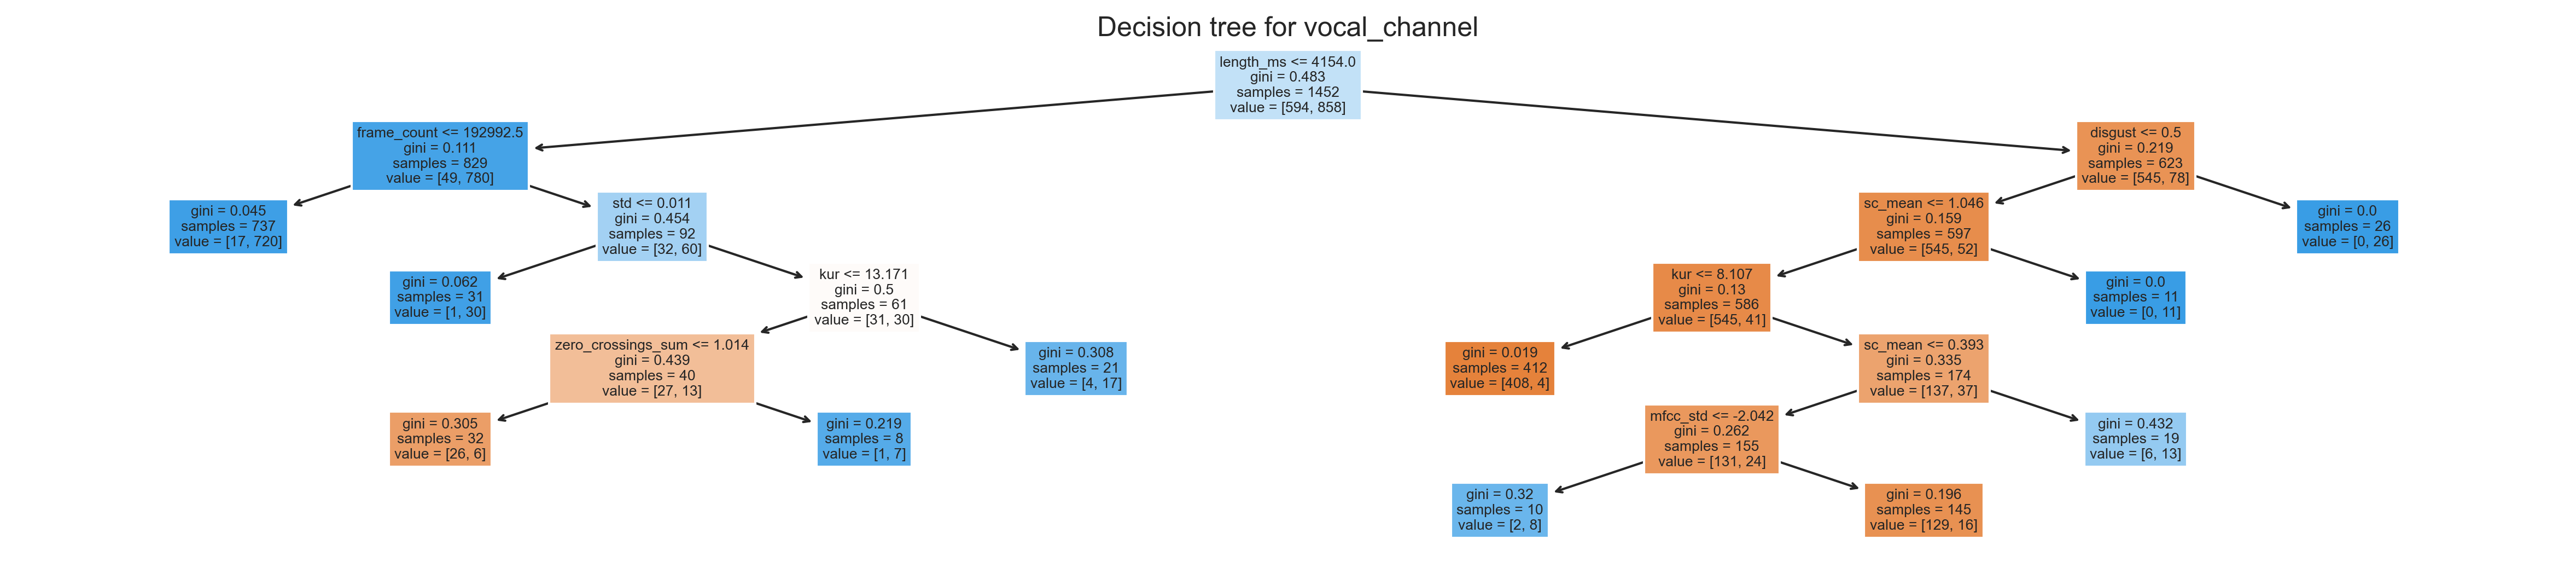

In [29]:
plt.figure(figsize=(20, 4), dpi=300)
plot_tree(clf, feature_names=df.columns, filled=True)
plt.title('Decision tree for vocal_channel')
plt.show()

In [30]:
y_test_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_test_pred))
print(f1_score(y_test, y_test_pred, average='macro'))

0.9484536082474226
0.9464417440776716


In [31]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       199
           1       0.95      0.97      0.96       286

    accuracy                           0.95       485
   macro avg       0.95      0.94      0.95       485
weighted avg       0.95      0.95      0.95       485



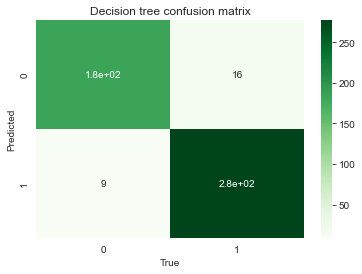

In [32]:
cf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Decision tree confusion matrix')
plt.show()

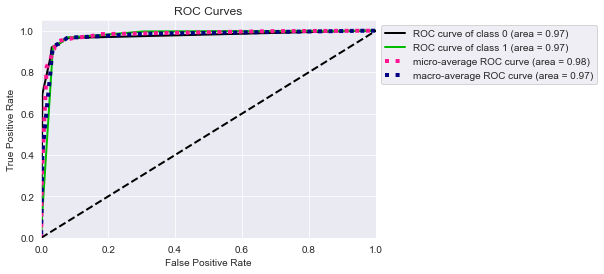

0.9737410830375655


In [33]:
y_test_pred_proba = clf.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

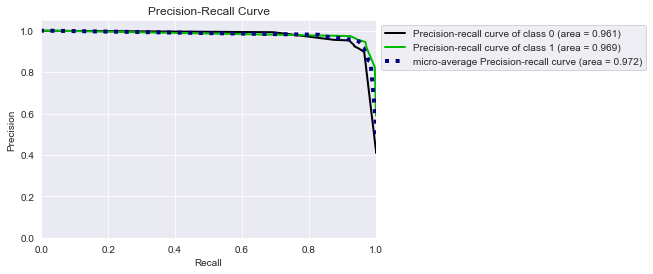

In [34]:
plot_precision_recall(y_test, clf.predict_proba(X_test))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

# Decision Tree without post-pruning

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0
)

In [36]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1694, 30) (727, 30) (1694,) (727,)


In [37]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

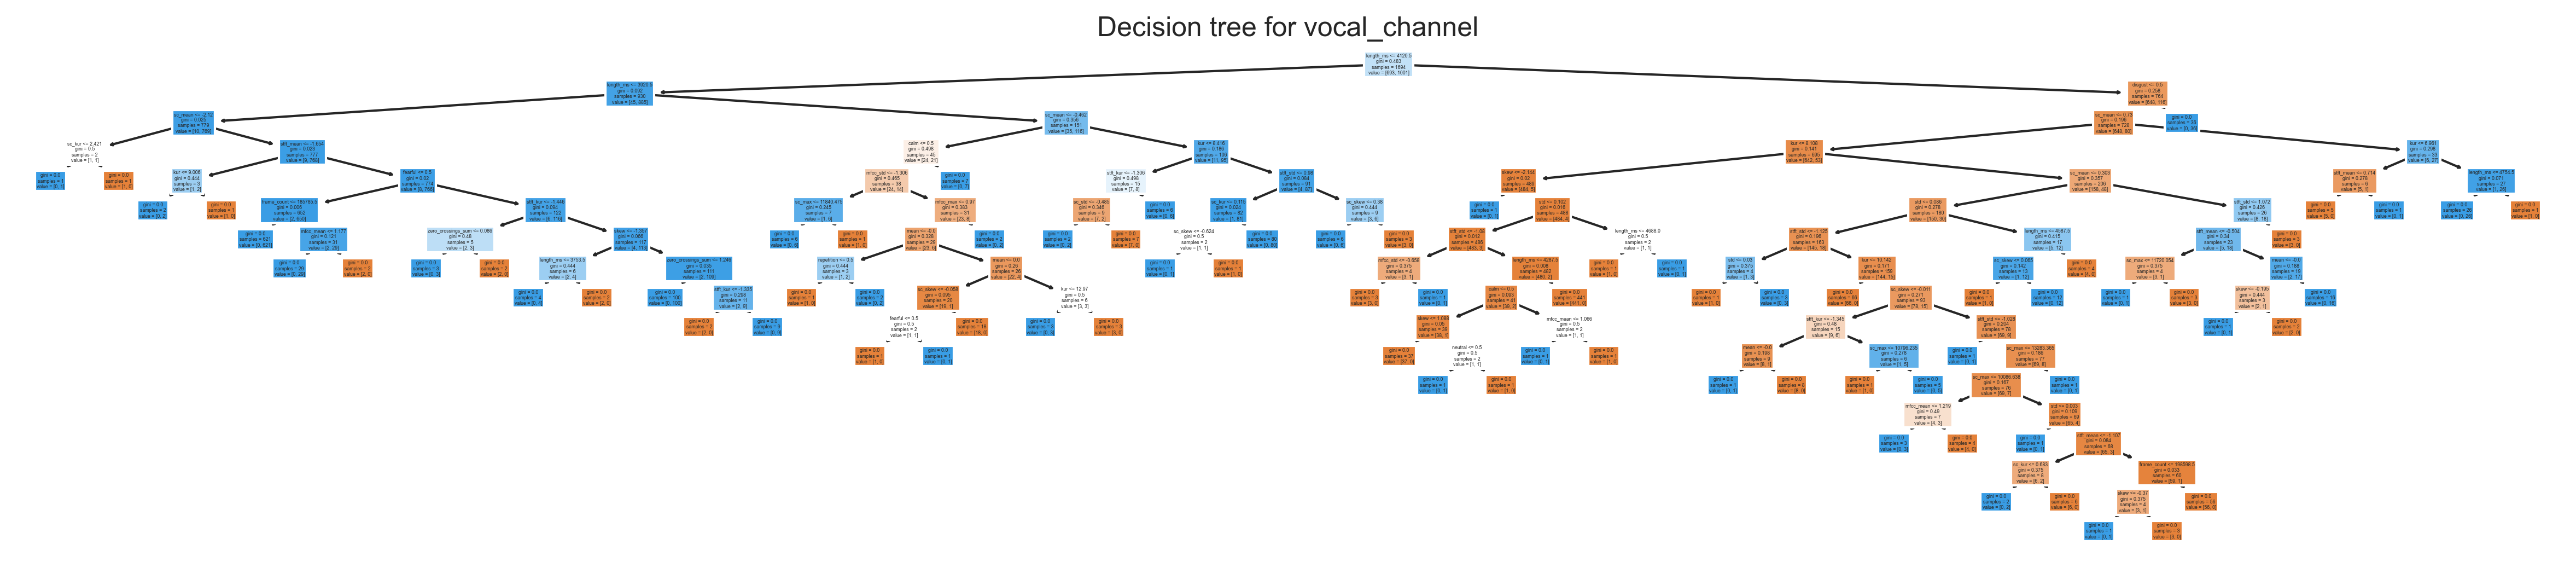

In [38]:
plt.figure(figsize=(20, 4), dpi=300)
plot_tree(clf, feature_names=df.columns, filled=True)
plt.title('Decision tree for vocal_channel')
plt.show()

In [39]:
param_grid = {
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 3, 5, 10],
    'max_depth': [2, 4, 6, 8, 10, 16, None],
    'criterion': ['gini', 'entropy', 'log_loss']
}

grid = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0),
    n_jobs=-1,
    refit=True,
)

In [40]:
grid.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=0),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4, 6, 8, 10, 16, None],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'min_samples_split': [2, 3, 5, 10]})

In [41]:
clf = grid.best_estimator_

In [42]:
print(grid.best_params_, grid.best_score_)

{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 5} 0.9348286816428408


In [43]:
clf.score(X_test, y_test)

0.9394773039889959

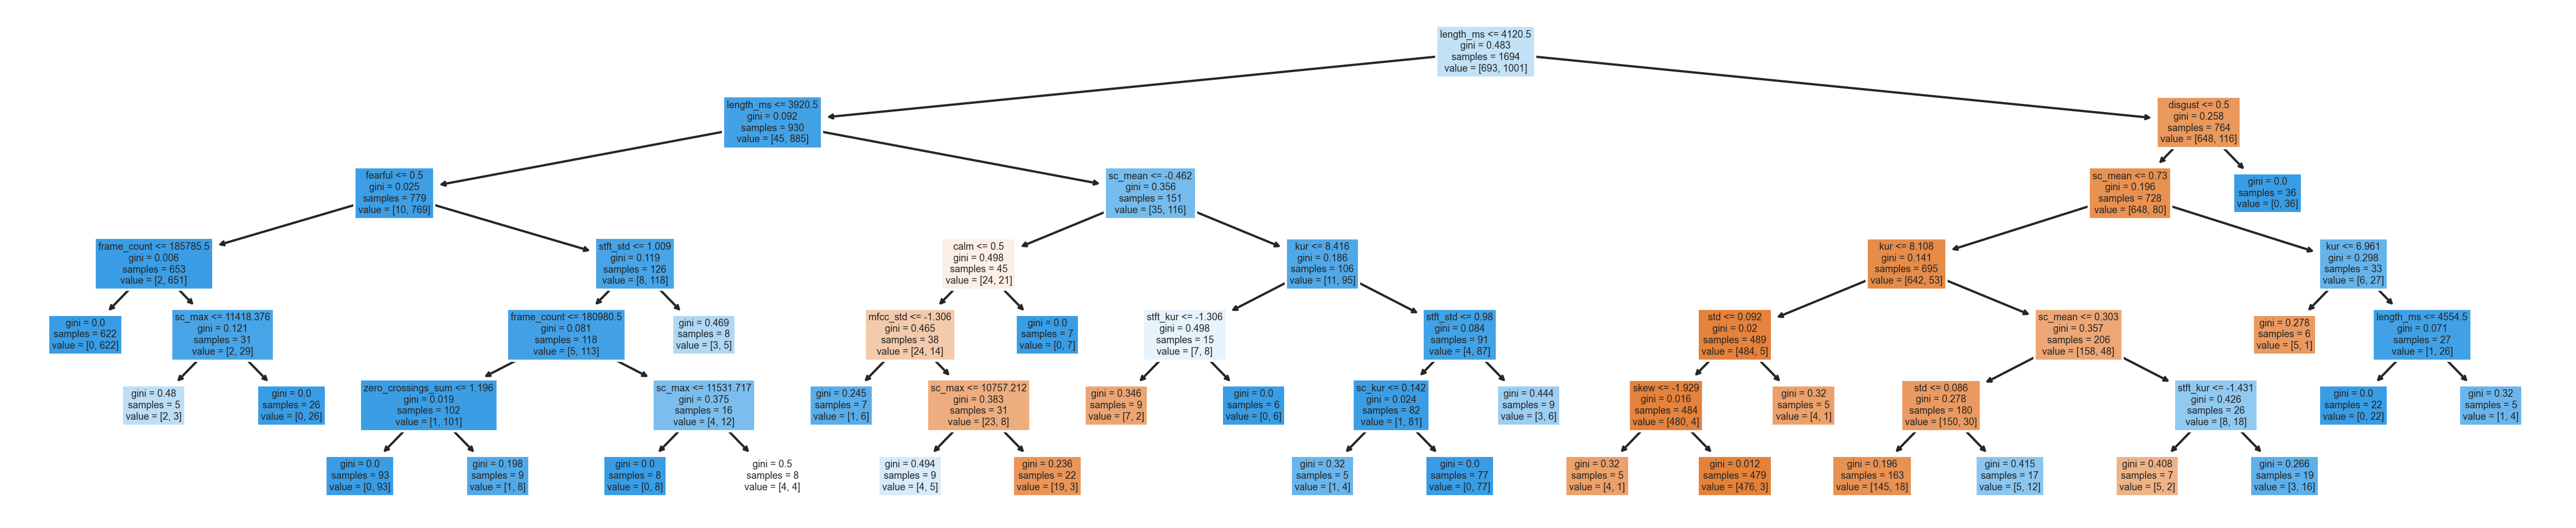

In [44]:
plt.figure(figsize=(20, 4), dpi=300)
plot_tree(clf, feature_names=df.columns, filled=True)
plt.show()

In [45]:
y_test_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_test_pred))
print(f1_score(y_test, y_test_pred, average='macro'))

0.9394773039889959
0.9378680755186077


In [46]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       298
           1       0.96      0.93      0.95       429

    accuracy                           0.94       727
   macro avg       0.94      0.94      0.94       727
weighted avg       0.94      0.94      0.94       727



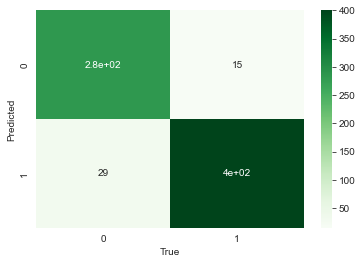

In [47]:
cf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

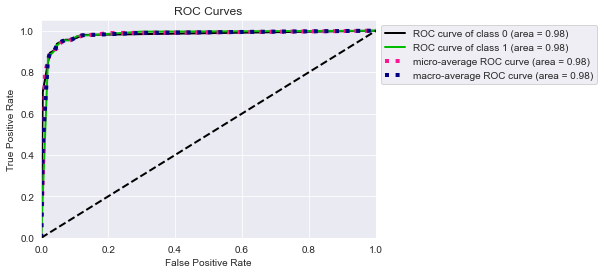

0.9784225841272821


In [48]:
y_test_pred_proba = clf.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

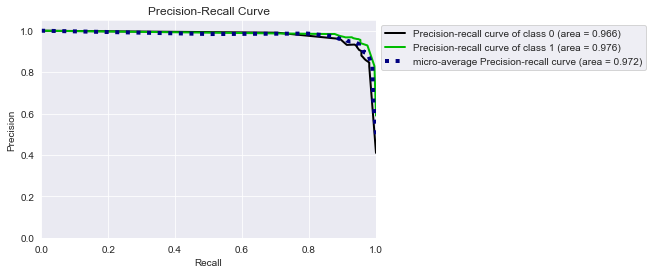

In [49]:
plot_precision_recall(y_test, clf.predict_proba(X_test))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

# KNN

In [50]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scal = scaler.transform(X_train)
X_test_scal = scaler.transform(X_test)

In [51]:
N = X_train.shape[0]
K = int(math.sqrt(N))
clf = KNeighborsClassifier(n_neighbors=K, metric='cityblock', weights='distance')
clf.fit(X_train_scal, y_train)

KNeighborsClassifier(metric='cityblock', n_neighbors=41, weights='distance')

In [52]:
clf.score(X_test_scal, y_test)

0.9477303988995873

In [53]:
param_grid = {
    'n_neighbors': np.arange(1, 200 // 2),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'cityblock'],
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
)
grid.fit(X_train_scal, y_train)
clf = grid.best_estimator_

In [54]:
print(grid.best_params_, grid.best_score_)

{'metric': 'cityblock', 'n_neighbors': 99, 'weights': 'distance'} 0.9439803808626135


In [55]:
clf.score(X_test_scal, y_test)

0.953232462173315

In [56]:
results = pd.DataFrame(grid.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,...,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001262,0.001256,0.027323,0.017901,euclidean,1,uniform,"{'metric': 'euclidean', 'n_neighbors': 1, 'wei...",0.828909,0.879056,...,0.890855,0.875740,0.840708,0.887906,0.879056,0.855457,0.831361,0.866827,0.018759,331
1,0.000693,0.000626,0.010866,0.004098,euclidean,1,distance,"{'metric': 'euclidean', 'n_neighbors': 1, 'wei...",0.828909,0.879056,...,0.890855,0.875740,0.840708,0.887906,0.879056,0.855457,0.831361,0.866827,0.018759,331
2,0.000609,0.000410,0.022464,0.005945,euclidean,2,uniform,"{'metric': 'euclidean', 'n_neighbors': 2, 'wei...",0.796460,0.867257,...,0.814159,0.822485,0.790560,0.793510,0.870206,0.820059,0.837278,0.831999,0.020544,368
3,0.000617,0.000807,0.011783,0.006027,euclidean,2,distance,"{'metric': 'euclidean', 'n_neighbors': 2, 'wei...",0.828909,0.879056,...,0.890855,0.875740,0.840708,0.887906,0.879056,0.855457,0.831361,0.866827,0.018759,331
4,0.000695,0.000518,0.025518,0.006683,euclidean,3,uniform,"{'metric': 'euclidean', 'n_neighbors': 3, 'wei...",0.825959,0.899705,...,0.864307,0.890533,0.817109,0.867257,0.887906,0.858407,0.860947,0.866944,0.019815,330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,0.000583,0.000270,0.039835,0.004959,cityblock,97,distance,"{'metric': 'cityblock', 'n_neighbors': 97, 'we...",0.935103,0.952802,...,0.958702,0.955621,0.926254,0.943953,0.952802,0.938053,0.937870,0.943804,0.010230,2
392,0.000517,0.000345,0.047397,0.005422,cityblock,98,uniform,"{'metric': 'cityblock', 'n_neighbors': 98, 'we...",0.932153,0.949853,...,0.955752,0.949704,0.914454,0.946903,0.949853,0.932153,0.934911,0.940617,0.012333,27
393,0.000625,0.000410,0.038403,0.004128,cityblock,98,distance,"{'metric': 'cityblock', 'n_neighbors': 98, 'we...",0.926254,0.949853,...,0.955752,0.955621,0.923304,0.943953,0.952802,0.938053,0.937870,0.942800,0.011173,10
394,0.000843,0.000214,0.048906,0.011764,cityblock,99,uniform,"{'metric': 'cityblock', 'n_neighbors': 99, 'we...",0.929204,0.955752,...,0.955752,0.958580,0.920354,0.941003,0.952802,0.938053,0.934911,0.942388,0.011628,13


In [57]:
results['metric_weight'] = results['param_metric'] + ', ' + results['param_weights']

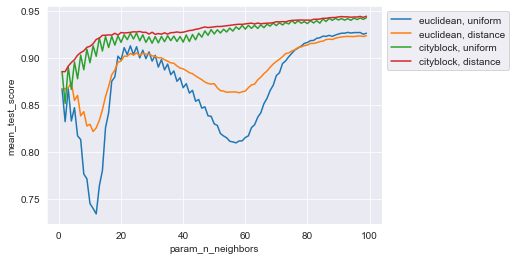

In [58]:
sns.lineplot(data=results, x='param_n_neighbors', y='mean_test_score', hue='metric_weight')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [59]:
y_test_pred = clf.predict(X_test_scal)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95       298
           1       0.99      0.93      0.96       429

    accuracy                           0.95       727
   macro avg       0.95      0.96      0.95       727
weighted avg       0.96      0.95      0.95       727



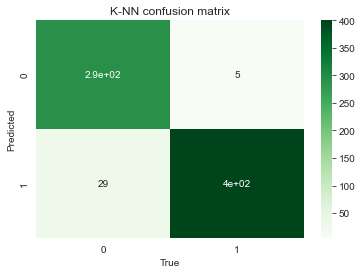

In [60]:
cf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('K-NN confusion matrix')
plt.show()

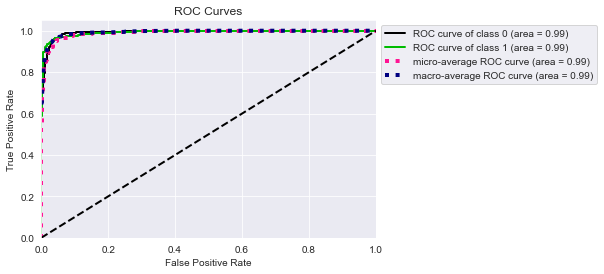

0.9918336696860186


In [61]:
y_test_pred_proba = clf.predict_proba(X_test_scal)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

# Naive Bayes
## Gaussian

In [62]:
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB()

In [63]:
clf.score(X_test, y_test)

0.9270976616231087

In [64]:
y_test_pred = clf.predict(X_test)

In [65]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       298
           1       0.96      0.91      0.94       429

    accuracy                           0.93       727
   macro avg       0.92      0.93      0.93       727
weighted avg       0.93      0.93      0.93       727



In [66]:
clf.predict_proba(X_test)

array([[4.42035472e-07, 9.99999558e-01],
       [3.48303772e-03, 9.96516962e-01],
       [9.67777953e-02, 9.03222205e-01],
       ...,
       [9.99997414e-01, 2.58628839e-06],
       [9.99969265e-01, 3.07350741e-05],
       [9.99841971e-01, 1.58029009e-04]])

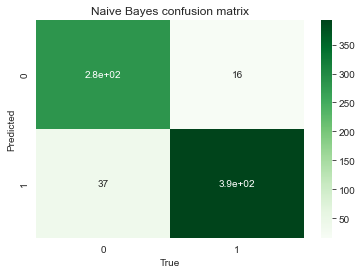

In [67]:
cf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Naive Bayes confusion matrix')
plt.show()

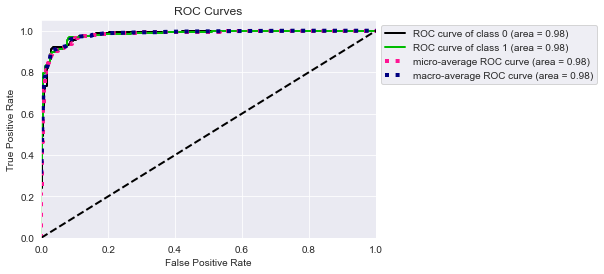

0.982055975344566


In [68]:
y_test_pred_proba = clf.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))